# Simulation for Dynamic Decision Optimisation

- skip_exec: true


In [ ]:
from pathlib import Path

import graphviz
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from torch.utils.data import Dataset, DataLoader

pd.set_option("display.max_columns", None)

PROJECT_ROOT = Path.cwd().parent.parent


## Introduction


In static optimisation, the decisions you make in any given period don't affect the decisions you need to make in a subsequent period. For instance, if the goods you stock will perish before your next order arrives you can treat the orders as being independent. However, if the items do not perish then and overstock in week 1 will affect the what the optimal amount to order in week 2 is.

In static optimisation you have a `state`. The `agent` is the decision maker i.e us or the code that we write. The agent takes an `action` i.e. placing an order with the wholesaler. The environment is what happens i.e. what the demand is in the coming week. We can then calculate a `reward` which in this case could be the profit we make.


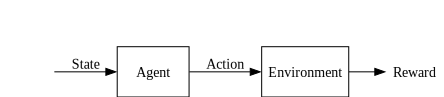

In [ ]:
s = """
State[shape=none label=""]
Agent[shape=box width=1 height=0.7]
Action[shape=none label=""]
Environment[shape=box width=1 height=0.7]
Reward[shape=none, width=0, label="Reward"]
State->Agent [label="State"]
Agent->Environment [label="Action"]
Environment->Reward
"""
graphviz.Source(f'digraph G{{rankdir="LR"; margin="0"; pad="0"; bgcolor="transparent"; {s}}}')

In dynamic optimisation, the `State` of the world is determined in part from a path that is your `Agent` making decisions e.g. how much to order. The `Environment` e.g. the demand that week will determine the outcome and therefore the `Reward`. However it will also feed back into the `State` that we are in next time we need to make a decision, in our example by carrying forward surplus stock to the next week.


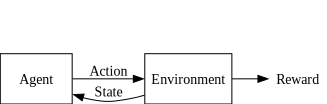

In [ ]:
s = """
Agent[shape=box width=1 height=0.7]
Action[shape=none label=""]
Environment[shape=box width=1 height=0.7]
Reward[shape=none, width=0, label="Reward"]
Agent->Environment [label="Action"]
Environment->Agent [label="State"]
Environment->Reward
"""
graphviz.Source(f'digraph G{{rankdir="LR"; margin="0"; pad="0"; bgcolor="transparent"; {s}}}')


### When to use dynamic optimisation


Simulation and dynamic optimsiation are much more complicated than static optimisation. So when do you need it?

- **One shot vs sequentially connected decisions**: The most important factor to consider is whether each decision is one-shot or whether the decision you make today will affect the situation you are in tommorow.
- **Certain vs uncertain long-term payoffs**: If you are reasonably sure what the payoffs of each decsion will be then you can use static optimisation. If not, you may need to model out the different paths a decision could lead you down.
- **Immediate vs long-term payoffs**: You could have situations where the decsisions are technically sequential but the pay offs are so soon that you can use a static model.


#### Examples:


- **Telecom churn prediction and reduction**: This can probably be done with static optimisation. However if a person stays with you, you may want to think about whether you give them a discount next month or the month after that. The decision you make may depend upon the discounts you have or have not given them in the preceding months. In this case, you may want to introduce a dynamic element to your optimisation.
- **Retail Inventory Management**: As discussed elsewhere this usually requires a dynamic framing unless the stock will all perish before the next order arrives.
- **Hotel Pricing**: This one is also best treated dynamically. If you have room available several months in the future and you don't sell it today you could sell still sell it later possibly at a different price.
- **Credit Underwriting**: This could be static problem. However, if you think this could turn into a recurring business relationship with a customer you may want to introduce a dynamic element to your model.


## Data Preparation


In [ ]:
all_data = pd.read_csv(f"{PROJECT_ROOT}/data/grupo-bimbo-inventory-demand/train.csv", low_memory=True)

print(all_data.shape)
all_data.head()


(74180464, 11)


,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil
0,3,1110,7,3301,15766,1212,3,25.14,0,0.0,3
1,3,1110,7,3301,15766,1216,4,33.52,0,0.0,4
2,3,1110,7,3301,15766,1238,4,39.32,0,0.0,4
3,3,1110,7,3301,15766,1240,4,33.52,0,0.0,4
4,3,1110,7,3301,15766,1242,3,22.92,0,0.0,3


These columns represent:

| Column              | Description                                         |
| ------------------- | --------------------------------------------------- |
| `Semana`            | The week number                                     |
| `Agencia_ID`        | The ID of the store                                 |
| `Canal_ID`          | The ID of the sales channel                         |
| `Ruta_SAK`          | The ID of the route                                 |
| `Cliente_ID`        | The ID of the client                                |
| `Producto_ID`       | The ID of the product                               |
| `Venta_uni_hoy`     | Number of units sold                                |
| `Venta_hoy`         | Sales value                                         |
| `Dev_uni_proxima`   | Number of units returned                            |
| `Dev_proxima`       | Returns value                                       |
| `Demanda_uni_equil` | Demand. This is our target columm in a static model |

How can we set up our data for a dynamic model? Normally in machine learning we want our training data to be from a time before our validation data.

We only have data from week 3 to week 9. For a project like this it is probably best to separate this into a couple of weeks of training data followed by a couple of weeks of validation data followed a long time to test how different decision making strategies play out over time. For this example we just use weeks 3 and 4 as training data and week 5 on wards as testing data.


In [ ]:
all_data["Semana"].value_counts().sort_index()

Semana
3    11165207
4    11009593
5    10615397
6    10191837
7    10382849
8    10406868
9    10408713
Name: count, dtype: int64

In [ ]:
MIN_ML_MODEL_WEEK = 3
MAX_ML_MODEL_WEEK = 4
MIN_DECISION_MODEL_WEEK = 5
MAX_DECISION_MODEL_WEEK = 9

The next thing to do is to check how much missing data we have. Each row is defined by the combination of IDs linked to it. So we can group the items by that list of IDs. We then see how in many different weeks that combination of IDs occurs.


In [ ]:
store_product_group_cols = ["Agencia_ID", "Canal_ID", "Ruta_SAK", "Cliente_ID", "Producto_ID"]
store_product_value_counts = all_data.groupby(store_product_group_cols).size()

In [ ]:
all_data.groupby(store_product_group_cols)["Semana"].nunique().describe()

count    2.639665e+07
mean     2.810223e+00
std      1.964561e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      7.000000e+00
Name: Semana, dtype: float64

Most of the combinations of IDs do not appear in every week. In a real project we would investigate why. Perhaps the data is missing. Perhaps those combinations represent products introduced or retired during the time period. Perhaps it means there was just no demand and we can fill those cases with zeros. For this example we will just drop the rows which don't have the full 7 weeks of data.


In [ ]:
full_filled_data = all_data.set_index(store_product_group_cols)
full_filled_data = full_filled_data.loc[store_product_value_counts == 7]
full_filled_data.reset_index(inplace=True)


In [ ]:
full_filled_data.shape

(17606645, 11)

We will now split our data by week as discussed above


In [ ]:
prediction_data = full_filled_data.query("Semana >= @MIN_ML_MODEL_WEEK and Semana <= @MAX_ML_MODEL_WEEK")
decision_data = full_filled_data.query("Semana >= @MIN_DECISION_MODEL_WEEK and Semana <= @MAX_DECISION_MODEL_WEEK")


## Model training


In [ ]:
SAMPLE_SIZE = 500_000

In [ ]:
num_unique_vals = {col: prediction_data[col].nunique() for col in store_product_group_cols}
data = prediction_data.sample(SAMPLE_SIZE, random_state=0)

In [ ]:
X_categorical = data[store_product_group_cols].values
X_numerical = data[["Venta_uni_hoy", "Venta_hoy"]].values
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_categorical = encoder.fit_transform(X_categorical)
y = data["Demanda_uni_equil"].values

In [ ]:
X_train_cat, X_val_cat, y_train, y_val = train_test_split(X_categorical, y, test_size=0.2, random_state=0)
X_train_num, X_val_num, _, _ = train_test_split(X_numerical, y, test_size=0.2, random_state=0)


In [ ]:
class BimboDataset(Dataset):
    def __init__(self, X_cat, X_num, y):
        self.X_cat = [torch.tensor(X_cat[:, i], dtype=torch.long) for i in range(X_cat.shape[1])]
        self.X_num = torch.tensor(X_num, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x_cat = [x[idx] for x in self.X_cat]
        # x_cat = self.X_cat[idx]
        x_num = self.X_num[idx]
        y = self.y[idx]
        return (x_cat, x_num), y


In [ ]:
train_dataset = BimboDataset(X_train_cat, X_train_num, y_train)
val_dataset = BimboDataset(X_val_cat, X_val_num, y_val)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [ ]:
class SimpleModel(nn.Module):
    def __init__(self, categorical_cols, num_unique_vals, hidden_size=128, num_features=2):
        super(SimpleModel, self).__init__()
        embedding_size = 50
        self.embeddings = nn.ModuleList(
            [nn.Embedding(num_unique_vals[col], embedding_size) for col in categorical_cols]
        )
        self.num_layer = nn.Linear(num_features, embedding_size)  # define a linear layer for numerical inputs
        self.fc1 = nn.Linear(
            embedding_size * len(num_unique_vals) + embedding_size, hidden_size
        )  # add embedding_size to input features of fc1 to account for the numerical inputs
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)

    def forward(self, x_cat, x_num):
        x_cat = [embedding(x_i.clip(0)) for x_i, embedding in zip(x_cat, self.embeddings)]
        x_cat = torch.cat(x_cat, dim=-1)
        x_num = torch.relu(self.num_layer(x_num))
        x = torch.cat([x_cat, x_num], dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x).squeeze(-1)
        return x

In [ ]:
def train_model(loss_fn, num_epochs=2):
    model = SimpleModel(store_product_group_cols, num_unique_vals)
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for (inputs_cat, inputs_num), targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs_cat, inputs_num).squeeze()
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_targets = []
        with torch.no_grad():
            for (inputs_cat, inputs_num), targets in val_loader:
                outputs = model(inputs_cat, inputs_num).squeeze()
                loss = loss_fn(outputs, targets)
                val_loss += loss.item()
                val_preds.extend(outputs.tolist())
                val_targets.extend(targets.tolist())

        val_loss /= len(val_loader)
        r2 = r2_score(val_targets, val_preds)
        print(f"Epoch: {epoch+1} | Train loss: {train_loss:.3f} | Val loss: {val_loss:.3f} | R2: {r2:.3f}")
    return model

In [ ]:
loss = nn.MSELoss()
model = train_model(loss, num_epochs=5)


Epoch: 1 | Train loss: 34.597 | Val loss: 4.531 | R2: 0.996
Epoch: 2 | Train loss: 11.584 | Val loss: 19.578 | R2: 0.984
Epoch: 3 | Train loss: 10.123 | Val loss: 4.529 | R2: 0.996
Epoch: 4 | Train loss: 10.495 | Val loss: 4.654 | R2: 0.996
Epoch: 5 | Train loss: 12.204 | Val loss: 14.114 | R2: 0.988


## Simulation loop


At a high level the heart of the simulation code is going to be a for loop. We will loop through all the periods i.e weeks. First we'll calculate what happens in week 1. Given what happens in week 1 we will calculate what happens in week 2. Given what happens in week 2 we will calculate what happens in week 3 and so on.

In some cases it is necessary to see what the decisions were in period 1 to know what the inputs to the model will be in period 2. In our case the thing our model is predicting is demand, not how much we sell but how much customers want to buy. The decsisions we make around stocking will not affect how much customers want to buy (there is a caveat here around whether the measure of demand is accurate. For instance the record of historical demand may appear to have a cap at the amount of stock that the shop had in the past. We'll set that aside for now). This means we can calculate our model's predictions up front.


We'll begin my by getting predictions for a single combination of IDs over the test period.


In [ ]:
sample_store_and_product = decision_data.query(
    "Agencia_ID == 1110 & Canal_ID == 7 & Ruta_SAK == 3301 & Cliente_ID == 15766 & Producto_ID == 1238"
)


### Model predictions


The following function will return our model's predictions as a new column called `predicted_demand`


In [ ]:
def add_preds_to_df(df, categorical_cols, continuous_cols):
    categorical_for_prediction = df[categorical_cols].values
    categorical_encoded = encoder.transform(categorical_for_prediction)
    categorical_tensor = torch.from_numpy(categorical_encoded).long()
    categorical_tensor = [categorical_tensor[:, i] for i in range(categorical_tensor.shape[1])]
    numerical_tensor = torch.from_numpy(df[continuous_cols].values).float()
    model.eval()
    with torch.no_grad():
        prediction = model(categorical_tensor, numerical_tensor)
    return df.assign(predicted_demand=prediction.numpy())


In [ ]:
add_preds_to_df(sample_store_and_product, store_product_group_cols, ["Venta_uni_hoy", "Venta_hoy"])


,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Semana,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,predicted_demand
5030470,1110,7,3301,15766,1238,5,1,9.83,0,0.0,1,2.677737
7545705,1110,7,3301,15766,1238,6,2,19.66,0,0.0,2,3.002397
10060940,1110,7,3301,15766,1238,7,2,19.66,0,0.0,2,3.002397
12576175,1110,7,3301,15766,1238,8,3,29.49,0,0.0,3,3.258899
15091410,1110,7,3301,15766,1238,9,2,19.66,0,0.0,2,3.002397


### Simulation loop


Let's demonstrate how the predicted and actual demand will affect the sales, suplus, and shortage we have over a few weeks. This is the sort of thing you might want to do in a spreadsheet. However we can also do it in code. We'll start by inventing some dummy values for predicted and actual demand.

In the first week of our simulation we obviously have no old stock.

We'll assume a rule of "order 10% more than the forecasted demand.

The amount we actually sell is the minimum of the actual demand and how much we we have in stock. How much we have in stock is the sum of the old stock and the new stock we ordered.

The shortage is how much people want to buy minus how much we are actually able to sell them.

The amount spoiled will depend on the specific shelf life of whatever product or products you are modelling. It may also depend on whether you can always sell old stock before new stock. We are going to make the assumptions we can keep stock on sale for 1 week _and_ that we can always sell old stock before new stock. So the amount spoiled will be the maximum of zero and the old stock minus actual demand. So:

- if actual demand was 20 and and we had 5 old stock, the amount spoiled would be 0.
- if actual demand was 2 and and we had 5 old stock, the amount spoiled would be 3.

Finally leftover stock can never be less than 0. Also because if we still have unsold old stock at the end of the week it will have spoiled we will only be able to carry the new stock over to the next week. So

- if actual demand was 20 and and we had 5 old stock and 10 new stock, the leftover stock would be 0.
- if actual demand was 10 and and we had 5 old stock and 10 new stock, the leftover stock would be 5.
- if actual demand was 10 and and we had 15 old stock and 10 new stock, the leftover stock would be 10.


In [ ]:
def create_simulation_table(actual_demand, forecasted_demand, decision_rule):
    df = pd.DataFrame()
    weeks = range(1, len(actual_demand) + 1)
    for week, actual_demand, forecasted_demand in zip(weeks, actual_demand, forecasted_demand):
        df.loc[week, "week"] = week
        df.loc[week, "actual_demand"] = actual_demand
        df.loc[week, "predicted_demand"] = forecasted_demand
        df.loc[week, "old_stock"] = 0 if week == 1 else df.loc[week - 1]["leftover_stock"]
        df.loc[week, "new_stock"] = decision_rule(df.loc[week])
        df.loc[week, "actually_sell"] = min(actual_demand, df.loc[week, "old_stock"] + df.loc[week, "new_stock"])
        df.loc[week, "shortage"] = actual_demand - df.loc[week, "actually_sell"]
        df.loc[week, "spoiled"] = max(df.loc[week, "old_stock"] - actual_demand, 0)
        df.loc[week, "leftover_stock"] = max(
            0, min((df.loc[week, "old_stock"] + df.loc[week, "new_stock"]) - actual_demand, df.loc[week, "new_stock"])
        )
    return df


Here we can see our simulation play out with some dummy data and a decision rule where we stock 10% more than the forecasted demand each week


In [ ]:
def add_ten_percent(state):
    return np.ceil(state["predicted_demand"] * 1.1)


create_simulation_table([5, 7, 3, 1, 6], [7, 3, 2, 4, 1], add_ten_percent)


,week,actual_demand,predicted_demand,old_stock,new_stock,actually_sell,shortage,spoiled,leftover_stock
1,1.0,5.0,7.0,0.0,8.0,5.0,0.0,0.0,3.0
2,2.0,7.0,3.0,3.0,4.0,7.0,0.0,0.0,0.0
3,3.0,3.0,2.0,0.0,3.0,3.0,0.0,0.0,0.0
4,4.0,1.0,4.0,0.0,5.0,1.0,0.0,0.0,4.0
5,5.0,6.0,1.0,4.0,2.0,6.0,0.0,0.0,0.0


Now let's apply it to the subset of data we used to test our model's predictions


In [ ]:
def add_simulation_to_table(df, categorical_cols, continuous_cols, decision_rule):
    df = add_preds_to_df(df, categorical_cols, continuous_cols)
    simulation_table = create_simulation_table(df["Demanda_uni_equil"], df["predicted_demand"], decision_rule)
    simulation_cols = ["old_stock", "new_stock", "actually_sell", "shortage", "spoiled", "leftover_stock"]
    df[simulation_cols] = simulation_table[simulation_cols].values
    return df

The decision rule here is even simpler; we just stock one item each week


In [ ]:
def first_decision_rule(state):
    return 1


add_simulation_to_table(
    sample_store_and_product, store_product_group_cols, ["Venta_uni_hoy", "Venta_hoy"], first_decision_rule
)


,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Semana,Venta_uni_hoy,Venta_hoy,Dev_uni_proxima,Dev_proxima,Demanda_uni_equil,predicted_demand,old_stock,new_stock,actually_sell,shortage,spoiled,leftover_stock
5030470,1110,7,3301,15766,1238,5,1,9.83,0,0.0,1,2.677737,0.0,1.0,1.0,0.0,0.0,0.0
7545705,1110,7,3301,15766,1238,6,2,19.66,0,0.0,2,3.002397,0.0,1.0,1.0,1.0,0.0,0.0
10060940,1110,7,3301,15766,1238,7,2,19.66,0,0.0,2,3.002397,0.0,1.0,1.0,1.0,0.0,0.0
12576175,1110,7,3301,15766,1238,8,3,29.49,0,0.0,3,3.258899,0.0,1.0,1.0,2.0,0.0,0.0
15091410,1110,7,3301,15766,1238,9,2,19.66,0,0.0,2,3.002397,0.0,1.0,1.0,1.0,0.0,0.0


### Scaling to multiple stores


To make the data a more manageable for our illustrative purposes we'll arbitrarily use the rows with an `Agencia_ID` of 1110 to pick our rule and the rows with an `Agencia_ID` of 24049 to test it.


In [ ]:
decision_validation_data = decision_data.query("Agencia_ID == 1110")
decision_holdout_data = decision_data.query("Agencia_ID == 24049")


The next step is to apply perform the simulation on multiple stores. We'll do this by grouping the data by `Agencia_ID` and then applying the simulation to each group.

Something to note here is the objective function. This is just an example of something you might come up with to help put a number on the combination of different outcomes that may arise as a result of different decision rules.


In [ ]:
def objective_function(df):
    return (
        df["actually_sell"].sum() - 3 * df["shortage"].sum() - 0.5 * df["spoiled"].sum() - 0.5 * df["old_stock"].sum()
    )

In [ ]:
def simulate_multiple_stores_and_products(raw_data, decision_function):
    groups = raw_data.groupby(store_product_group_cols)
    outcomes = pd.concat(
        [
            add_simulation_to_table(group, store_product_group_cols, ["Venta_uni_hoy", "Venta_hoy"], decision_function)
            for _, group in groups
        ]
    )
    return {
        "number_of_orders": outcomes["new_stock"].count(),
        "total_inventory_orders": outcomes["new_stock"].sum(),
        "number_of_shortages": (outcomes["shortage"] > 0).sum(),
        "total_shortage": outcomes["shortage"].sum(),
        "total_sold": outcomes["actually_sell"].sum(),
        "total_old_stock": outcomes["old_stock"].sum(),
        "total_spoiled": outcomes["spoiled"].sum(),
        "objective_function": objective_function(outcomes),
    }

We are also going to try out a few other possible decision rules so we can see how they may affect things. These are all a bit more realistic than just setting everything to be 1.


In [ ]:
def predicted_need(state):
    return np.ceil(state["predicted_demand"] - state["old_stock"])


def predicted_need_plus_one(state):
    return predicted_need(state) + 1


def predicted_demand(state):
    return np.ceil(state["predicted_demand"])

In [ ]:
outcomes = []
for rule in [predicted_need, predicted_need_plus_one, predicted_demand]:
    outcomes.append(simulate_multiple_stores_and_products(decision_validation_data, rule))

In [ ]:
outcomes_df = pd.DataFrame(outcomes)
outcomes_df["rule"] = ["predicted_need", "predicted_need_plus_one", "predicted_demand"]
outcomes_df

,number_of_orders,total_inventory_orders,number_of_shortages,total_shortage,total_sold,total_old_stock,total_spoiled,objective_function,rule
0,14270,339290.0,3535,11800.0,331317.0,28596.0,1205.0,281016.5,predicted_need
1,14270,345590.0,2086,8265.0,334852.0,36566.0,1977.0,290785.5,predicted_need_plus_one
2,14270,367886.0,3026,10991.0,332126.0,65324.0,8460.0,262261.0,predicted_demand


What are these results showing us? The `predicted_demand` rule simply orders however much we think we will sell. It ignores the amount we are carrying over from the previous week. It does the worst. It results in the most old stock being carried forward. This means it results in far more stock being spoiled. It also doesn't even result in lower shortages compared to the columns based on predicted need.

In this case ordering our predicted need with a buffer has come out slightly ahead of predicted need in our objective function. This makes sense has that function deliberately weights shortages more than spoilages. Whether those weights have been chosen correctly will depend upon your circumstances.


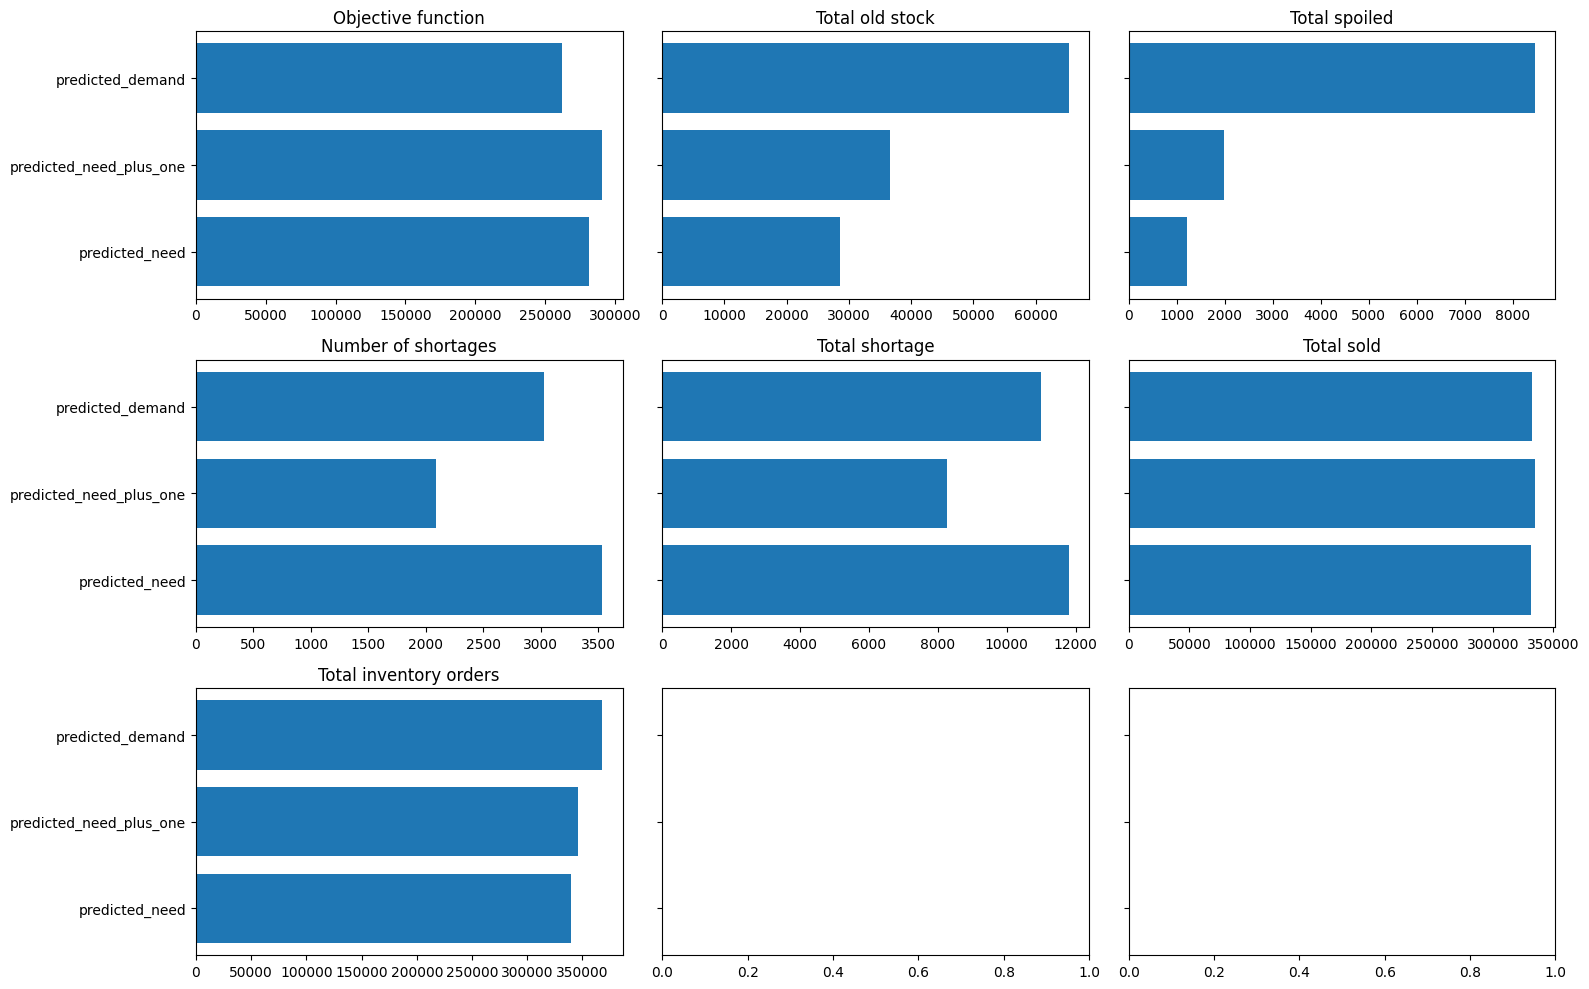

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(16, 10), sharey=True)
ax = ax.flatten()

ax[0].barh(outcomes_df["rule"], outcomes_df["objective_function"])
ax[0].set_title("Objective function")
ax[1].barh(outcomes_df["rule"], outcomes_df["total_old_stock"])
ax[1].set_title("Total old stock")
ax[2].barh(outcomes_df["rule"], outcomes_df["total_spoiled"])
ax[2].set_title("Total spoiled")
ax[3].barh(outcomes_df["rule"], outcomes_df["number_of_shortages"])
ax[3].set_title("Number of shortages")
ax[4].barh(outcomes_df["rule"], outcomes_df["total_shortage"])
ax[4].set_title("Total shortage")
ax[5].barh(outcomes_df["rule"], outcomes_df["total_sold"])
ax[5].set_title("Total sold")
ax[6].barh(outcomes_df["rule"], outcomes_df["total_inventory_orders"])
ax[6].set_title("Total inventory orders")

fig.tight_layout()

plt.show()

### Programmatic Optimisation


At this point you may choose to programmatically optimise you decision function parameters using something like a hyperparameter optimisation library from the scikit-learn ecosystem or Weights and Bias's sweep capabilities.


## References


- [Machine Learning for Business Decision Optimization](https://www.wandb.courses/courses/decision-optimization) - Dan Becker
